In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [12]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from blitz.modules import BayesianConv1d, BayesianLinear, BayesianGRU
from blitz.utils import variational_estimator

In [3]:
num_epochs = 100
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'raw'
modeltype = 'bayesian'
normalize = ""#"sample"

transforms_list_train = [Bandpass(), RandomFlip(), RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass()]

In [4]:
train_df = pd.read_csv('../data_created/suzmel_train.csv')
test_df = pd.read_csv('../data_created/suzmel_test.csv')

In [5]:
X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True)

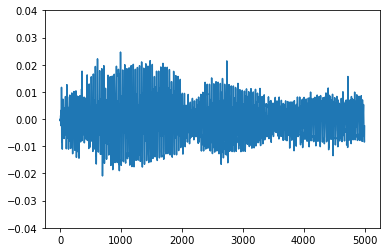

In [6]:
sig = test_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [22]:
@variational_estimator
class BayesianCNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = BayesianConv1d(1, 16, 3)
        self.soft1 = nn.Softplus()
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = BayesianConv1d(16, 32, 3)
        self.soft2 = nn.Softplus()
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = BayesianConv1d(32, 64, 3)
        self.soft3 = nn.Softplus()
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)

        self.conv4 = BayesianConv1d(64, 128, 3)
        self.soft4 = nn.Softplus()
        self.bn4 = nn.BatchNorm1d(128)
        self.pool4 = nn.MaxPool1d(2)

        self.conv5 = BayesianConv1d(128, 256, 3)
        self.soft5 = nn.Softplus()
        self.bn5 = nn.BatchNorm1d(256)
        self.pool5 = nn.MaxPool1d(2)

        self.conv6 = BayesianConv1d(256, 512, 3)
        self.soft6 = nn.Softplus()
        self.bn6 = nn.BatchNorm1d(512)
        self.pool6 = nn.MaxPool1d(2)        

        self.avgPool = nn.AdaptiveAvgPool2d((512,1))#nn.AvgPool1d(154)
        self.fc1 = BayesianLinear(512, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.softplus(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.softplus(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.softplus(x)
        x = self.bn3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = F.softplus(x)
        x = self.bn4(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = F.softplus(x)
        x = self.bn5(x)
        x = self.pool5(x)

        x = self.conv6(x)
        x = F.softplus(x)
        x = self.bn6(x)
        x = self.pool6(x)

        x = self.avgPool(x)
        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        return x

In [23]:
import metrics 

model = BayesianCNN1()

criterion = nn.CrossEntropyLoss() # metrics.ELBO(len(train_dataset))#
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=9, verbose=1)
# print(model)

## Training

In [24]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
#         optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / len(train_dataset) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / len(valid_dataset) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Train on gpu: True


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss decreased (inf --> 26.877522).  Saving model ...
Epoch 0: train_acc: 85.90% loss: 0.450,  val_loss: 26.878 val_acc: 60.71%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss decreased (26.877522 --> 8.938934).  Saving model ...
Epoch 1: train_acc: 91.52% loss: 0.270,  val_loss: 8.939 val_acc: 60.71%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss decreased (8.938934 --> 0.636797).  Saving model ...
Epoch 2: train_acc: 93.24% loss: 0.236,  val_loss: 0.637 val_acc: 77.14%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 3: train_acc: 93.75% loss: 0.005,  val_loss: 8.752 val_acc: 60.71%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 4: train_acc: 94.30% loss: 0.446,  val_loss: 1.453 val_acc: 55.00%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 5: train_acc: 94.53% loss: 0.047,  val_loss: 1.796 val_acc: 65.83%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 6: train_acc: 95.07% loss: 0.027,  val_loss: 4.278 val_acc: 63.17%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 7: train_acc: 95.32% loss: 0.895,  val_loss: 1.175 val_acc: 64.69%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8: train_acc: 95.64% loss: 0.003,  val_loss: 1.909 val_acc: 66.34%


Validating..	: 100%|██████████| 62/62 [00:01<00:00, 49.80it/s]


Validation loss decreased (0.636797 --> 0.136533).  Saving model ...


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 9: train_acc: 96.81% loss: 0.055,  val_loss: 0.137 val_acc: 93.91%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 10: train_acc: 97.14% loss: 0.031,  val_loss: 0.308 val_acc: 95.56%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss decreased (0.136533 --> 0.033391).  Saving model ...
Epoch 11: train_acc: 97.19% loss: 0.039,  val_loss: 0.033 val_acc: 95.13%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 12: train_acc: 97.34% loss: 0.173,  val_loss: 0.188 val_acc: 94.75%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Validation loss decreased (0.033391 --> 0.030349).  Saving model ...
Epoch 13: train_acc: 97.44% loss: 0.004,  val_loss: 0.030 val_acc: 95.33%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 14: train_acc: 97.40% loss: 0.032,  val_loss: 0.055 val_acc: 95.33%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 15: train_acc: 97.41% loss: 0.024,  val_loss: 0.451 val_acc: 92.31%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 16: train_acc: 97.52% loss: 0.002,  val_loss: 0.221 val_acc: 88.18%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 17: train_acc: 97.55% loss: 0.006,  val_loss: 0.107 val_acc: 93.07%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 18: train_acc: 97.55% loss: 0.022,  val_loss: 0.104 val_acc: 95.03%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 1.0000e-04.
Epoch 19: train_acc: 97.59% loss: 0.004,  val_loss: 0.335 val_acc: 90.99%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 20: train_acc: 97.74% loss: 1.280,  val_loss: 0.146 val_acc: 94.47%


Training..	:   0%|          | 0/825 [00:00<?, ?it/s]

Epoch 21: train_acc: 97.86% loss: 0.006,  val_loss: 0.134 val_acc: 94.29%


Validating..	: 100%|██████████| 62/62 [00:01<00:00, 50.37it/s]

Early stopping


## Testing on test set

In [431]:
test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 418/418 [00:07<00:00, 58.93it/s]

Accuracy: 88.44
Balanced accuracy: 87.84
Confusion matrix: 
[[0.81887861 0.18112139]
 [0.06202816 0.93797184]]


## Testing on extra mebios data

In [432]:
extra_df = pd.read_csv('../data_created/suzmel_extra.csv')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True)

In [433]:
test_model(model,extra_dataloader, extra_dataset)

Testing..	: 100%|██████████| 398/398 [00:06<00:00, 59.87it/s]

Accuracy: 89.25
Balanced accuracy: 88.15
Confusion matrix: 
[[0.8694517  0.1305483 ]
 [0.10640402 0.89359598]]


## Uncertainty

In [434]:
def get_uncertainty_per_wingbeat(model, input_wingbeat, T=15, normalized=True):
    outputs = np.stack([model(input_wingbeat.unsqueeze(0).cuda()).cpu().detach().numpy() for i in range(T)]).squeeze()
    net_out = torch.from_numpy(outputs)
    pred = torch.mean(net_out, dim=0).cpu().detach().numpy()
    if normalized:
        prediction = F.softplus(net_out)
        p_hat = prediction / torch.sum(prediction, dim=1).unsqueeze(1)
    else:
        p_hat = F.softmax(net_out, dim=1)
    p_hat = p_hat.detach().cpu().numpy()
    p_bar = np.mean(p_hat, axis=0)

    temp = p_hat - np.expand_dims(p_bar, 0)
    epistemic = np.dot(temp.T, temp) / T
    epistemic = np.diag(epistemic)

    aleatoric = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
    aleatoric = np.diag(aleatoric)

    return p_hat.mean(axis=0)[0],epistemic[0], aleatoric[0]

In [435]:
get_uncertainty_per_wingbeat(model, extra_dataset[20002][0].cuda(), T=15,normalized=True)
# print(np.round(pred,3), np.round(predsoft,3), np.round(epistemic,3), np.round(aleatoric,3))

(0.001732993, 2.2626996e-07, 0.0017297636)

In [523]:
def make_df(model, loader, dataset):
    model.eval()
    x, y, y_pred = [],[],[]
    for inputs,labels,_,_ in tqdm(loader, desc='Reading all files..\t'):        
        x.extend(inputs)
        y.extend(labels)
        outputs = model(inputs.cuda())
        _, preds = torch.max(outputs,1)
        y_pred.extend(preds.detach().cpu().numpy())

    df = pd.DataFrame({"x": x, "y": y, "preds": y_pred})
    df['y'] = df.y.apply(lambda x: int(x))
    return df

In [524]:
model = model.to('cuda', dtype=torch.float)

df = make_df(model, extra_dataloader, extra_dataset)
df['softmax0'], df['epistemic0'], df['aleatoric0'] = 0,0,0

Reading all files..	: 100%|██████████| 398/398 [00:07<00:00, 54.04it/s]


In [525]:
len(df[df.y==df.preds]) / len(df)

0.8961636828644501

In [526]:
%%time
inds = []
for q in tqdm(df.itertuples(), total=len(df)):
    i = q[0]
    df['softmax0'].loc[i], df['epistemic0'].loc[i], df['aleatoric0'].loc[i] = get_uncertainty_per_wingbeat(model, extra_dataset[i][0].cuda(), T=10, normalized=False)
    inds.append(i)
df['softmax1'] = 1- df['softmax0']
df['bayespred'] = df[['softmax0','softmax1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
len(df[df.y==df.bayespred]) / len(df)

  0%|          | 0/25415 [00:00<?, ?it/s]/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 25415/25415 [46:05<00:00,  9.19it/s]

CPU times: user 46min 8s, sys: 6.26 s, total: 46min 14s
Wall time: 46min 5s


0.9154436356482393

In [507]:
df = df.sample(5000)
len(df[df.y==df.preds]) / len(df)

0.8958

In [508]:
%%time
inds = []
for q in tqdm(df.itertuples(), total=len(df)):
    i = q[0]
    df['softmax0'].loc[i], df['epistemic0'].loc[i], df['aleatoric0'].loc[i] = get_uncertainty_per_wingbeat(model, extra_dataset[i][0].cuda(), T=10, normalized=False)
    inds.append(i)
df['softmax1'] = 1- df['softmax0']
df['bayespred'] = df[['softmax0','softmax1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
len(df[df.y==df.bayespred]) / len(df)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 5000/5000 [09:54<00:00,  8.41it/s]

CPU times: user 9min 55s, sys: 1.35 s, total: 9min 56s
Wall time: 9min 54s


In [522]:
0.9136

0.9136

In [521]:
%%time
inds = []
for q in tqdm(df.itertuples(), total=len(df)):
    i = q[0]
    df['softmax0'].loc[i], df['epistemic0'].loc[i], df['aleatoric0'].loc[i] = get_uncertainty_per_wingbeat(model, extra_dataset[i][0].cuda(), T=10, normalized=True)
    inds.append(i)
df['softmax1'] = 1- df['softmax0']
df['bayespred'] = df[['softmax0','softmax1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
len(df[df.y==df.bayespred]) / len(df)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 5000/5000 [09:24<00:00,  8.86it/s]

CPU times: user 9min 25s, sys: 1.09 s, total: 9min 26s
Wall time: 9min 24s


0.917

0.9136

In [439]:
%%time

# df = df[df.y==0].reset_index(drop=True)

points = len(df) # len(df) # for all points
inds = []
for q in tqdm(df.itertuples(), total=points):
    i = np.random.randint(0, len(df))
    df['softmax0'].loc[i], df['epistemic0'].loc[i], df['aleatoric0'].loc[i] = get_uncertainty_per_wingbeat(model, extra_dataset[i][0].cuda(), T=20, normalized=False)
    inds.append(i)
    if q[0] > points:
        break

  0%|          | 0/500 [00:00<?, ?it/s]/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
501it [01:44,  4.82it/s]                         

CPU times: user 1min 43s, sys: 266 ms, total: 1min 44s
Wall time: 1min 44s


In [440]:
# df.to_csv("../data_created/suzmelextra_uncertainty.csv")

In [441]:
df = df.loc[inds]
df['softmax1'] = 1 - df['softmax0']
df['predicted'] = df[['softmax0','softmax1']].idxmax(axis=1).apply(lambda x: int(x[-1]))

In [442]:
linspace = np.linspace(0.65,1,15)
def check_uncertain(df, metric):
    points_removed, missclassified_removed = [],[]
    for q in linspace:
        uncertain = df.query(f'{metric} > {metric}.quantile({q})')
        points_removed.append(uncertain.shape[0])
        missclassified_removed.append(uncertain[uncertain.y != uncertain.predicted].shape[0])
    return points_removed, missclassified_removed

In [443]:
df[df.predicted==df.y].shape

(61, 7)

In [453]:
df.y

230     0
1107    0
129     0
837     0
890     0
       ..
462     0
945     0
962     0
835     0
168     0
Name: y, Length: 502, dtype: object

In [444]:
df.predicted.value_counts()

1    441
0     61
Name: predicted, dtype: int64

## Suzukii mebios

softmax0 mean: 0.13, softmax1 mean: 0.87


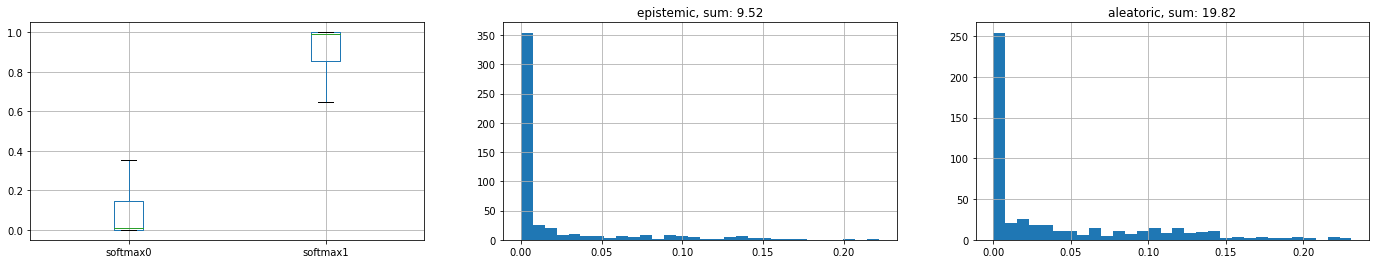

In [329]:
plt.figure(figsize=(24,4))
print(f"softmax0 mean: {df.softmax0.mean():.2f}, softmax1 mean: {df.softmax1.mean():.2f}")
plt.subplot(1,3,1);
df[['softmax0','softmax1']].boxplot(showfliers=False);
plt.subplot(1,3,2);
np.sum(df.epistemic0);
df.epistemic0.hist(bins=30); plt.title(f'epistemic, sum: {np.sum(df.epistemic0):.2f}');
plt.subplot(1,3,3);
np.sum(df.aleatoric0);
df.aleatoric0.hist(bins=30); plt.title(f'aleatoric, sum: {np.sum(df.aleatoric0):.2f}');

## Melanogaster mebios

softmax0 mean: 0.14, softmax1 mean: 0.86


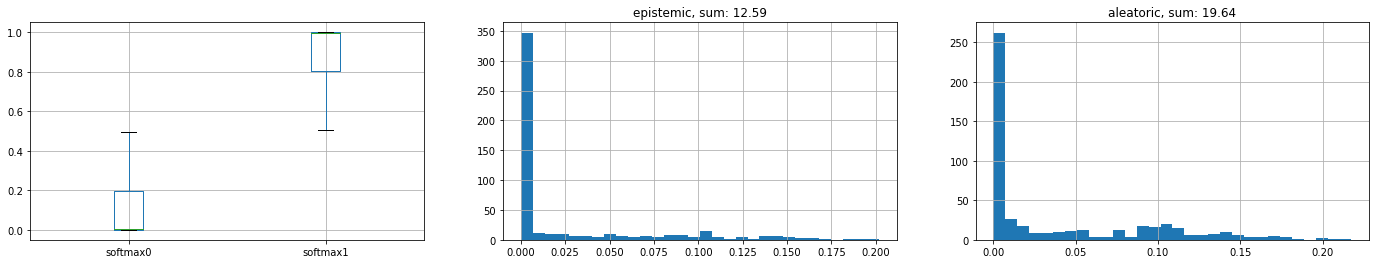

In [445]:
plt.figure(figsize=(24,4))
print(f"softmax0 mean: {df.softmax0.mean():.2f}, softmax1 mean: {df.softmax1.mean():.2f}")
plt.subplot(1,3,1);
df[['softmax0','softmax1']].boxplot(showfliers=False);
plt.subplot(1,3,2);
np.sum(df.epistemic0);
df.epistemic0.hist(bins=30); plt.title(f'epistemic, sum: {np.sum(df.epistemic0):.2f}');
plt.subplot(1,3,3);
np.sum(df.aleatoric0);
df.aleatoric0.hist(bins=30); plt.title(f'aleatoric, sum: {np.sum(df.aleatoric0):.2f}');

## Suz+Mel mebios

softmax0 mean: 0.14, softmax1 mean: 0.86


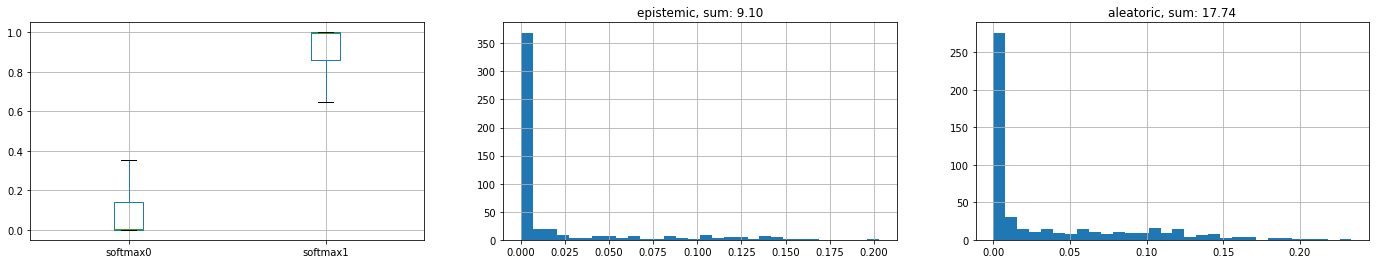

In [313]:
plt.figure(figsize=(24,4))
print(f"softmax0 mean: {df.softmax0.mean():.2f}, softmax1 mean: {df.softmax1.mean():.2f}")
plt.subplot(1,3,1);
df[['softmax0','softmax1']].boxplot(showfliers=False);
plt.subplot(1,3,2);
np.sum(df.epistemic0);
df.epistemic0.hist(bins=30); plt.title(f'epistemic, sum: {np.sum(df.epistemic0):.2f}');
plt.subplot(1,3,3);
np.sum(df.aleatoric0);
df.aleatoric0.hist(bins=30); plt.title(f'aleatoric, sum: {np.sum(df.aleatoric0):.2f}');

## C. pipiens

softmax0 mean: 0.25, softmax1 mean: 0.75


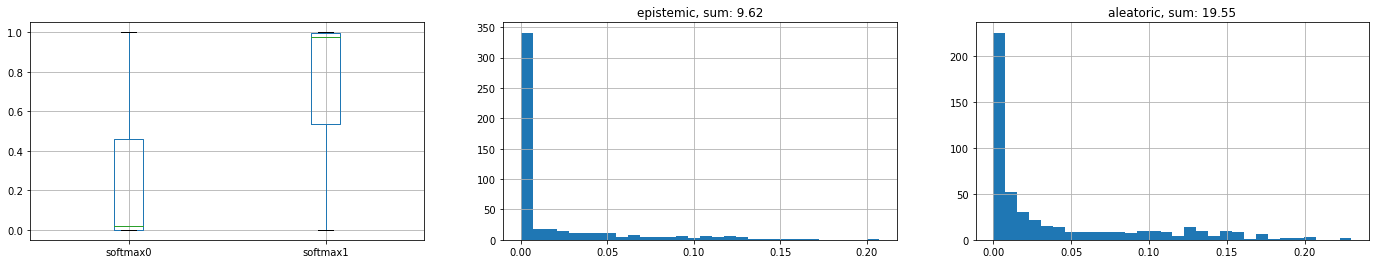

In [301]:
plt.figure(figsize=(24,4))
print(f"softmax0 mean: {df.softmax0.mean():.2f}, softmax1 mean: {df.softmax1.mean():.2f}")
plt.subplot(1,3,1);
df[['softmax0','softmax1']].boxplot(showfliers=False);
plt.subplot(1,3,2);
np.sum(df.epistemic0);
df.epistemic0.hist(bins=30); plt.title(f'epistemic, sum: {np.sum(df.epistemic0):.2f}');
plt.subplot(1,3,3);
np.sum(df.aleatoric0);
df.aleatoric0.hist(bins=30); plt.title(f'aleatoric, sum: {np.sum(df.aleatoric0):.2f}');

10.817327125008694

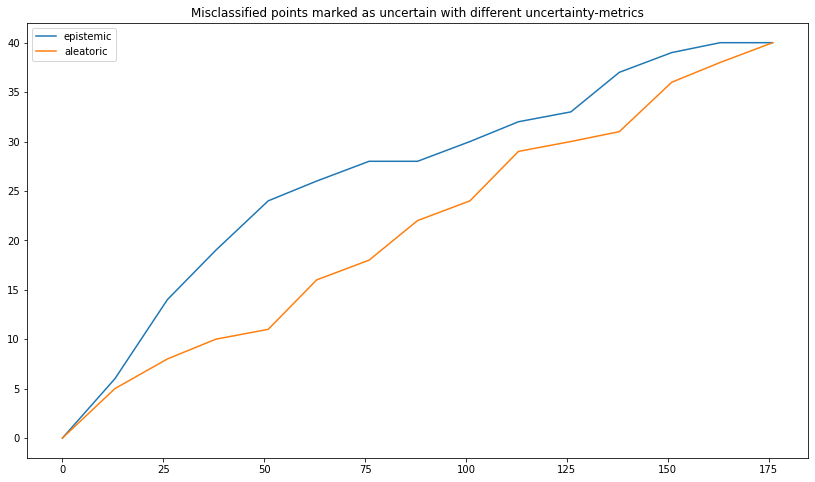

In [259]:
ep_pointsrem, ep_missclrem = check_uncertain(df, 'epistemic0')
al_pointsrem, al_missclrem = check_uncertain(df, 'aleatoric0')

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(111)
# ax2 = ax1.twiny()

a = np.linspace(0.65,1,11)

ax1.plot(ep_pointsrem, ep_missclrem)
ax1.plot(al_pointsrem,al_missclrem)
# ax2.plot(a,a);ax2.plot(a,a);ax2.plot(a,a);ax2.plot(a,a);
plt.title("Misclassified points marked as uncertain with different uncertainty-metrics");
plt.legend(['epistemic','aleatoric'], loc='upper left')
plt.show()

<AxesSubplot:title={'center':'Total missclassifications: 45'}>

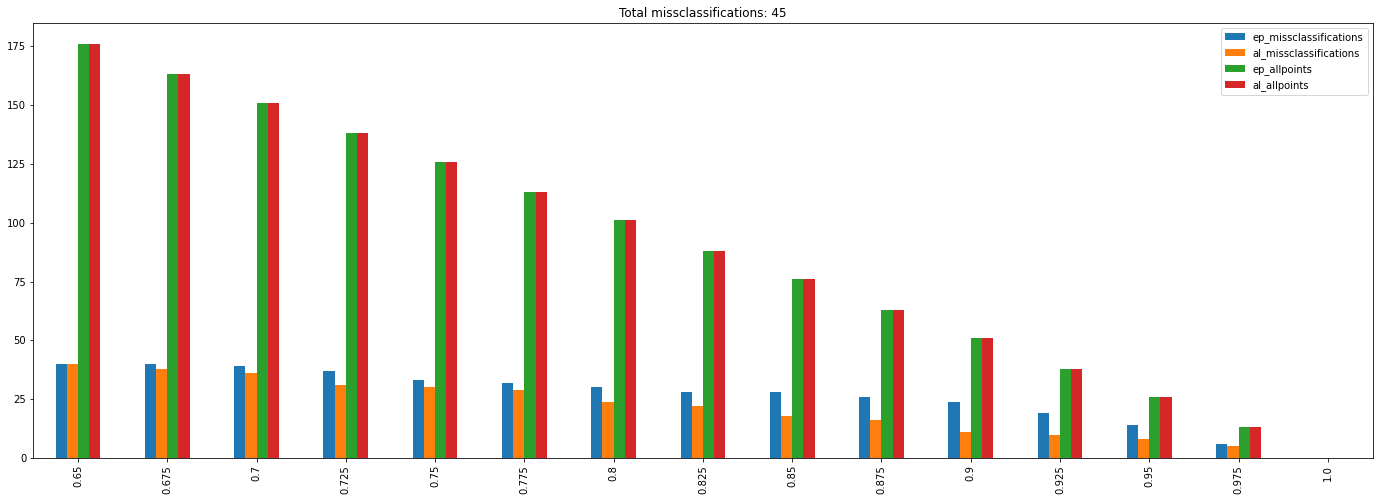

In [260]:
sub = pd.DataFrame({"ep_missclassifications": ep_missclrem, "al_missclassifications": al_missclrem, "ep_allpoints": ep_pointsrem, "al_allpoints": al_pointsrem})
sub.index = np.round(linspace,3)
sub.plot(kind='bar', figsize=(24,8), title=f"Total missclassifications: {df[df.y != df.predicted].shape[0]}")

# ‘bar’ or ‘barh’ for bar plots
# ‘hist’ for histogram
# ‘box’ for boxplot
# ‘kde’ or ‘density’ for density plots
# ‘area’ for area plots
# ‘scatter’ for scatter plots
# ‘hexbin’ for hexagonal bin plots
# ‘pie’ for pie plots

In [135]:
dpip = WingbeatsDataset(dsname="Wingbeats/C. pipiens", custom_label=[2], clean=True, transform=transforms.Compose(transforms_list_test))

Found 29475 in dataset: Wingbeats/C. pipiens, and 1 label(s): ['C. pipiens']
Label(s) changed to [2]


In [44]:
d = dsuz2
r = 4
for i in range(len(d)):
    q = np.random.randint(0,len(d))
    pr, ep, al = get_uncertainty_per_wingbeat(model, d[q][0].cuda())
    print(f"{np.round(pr, r)}, {np.round(ep, r)}, {np.round(al, r)}")
    if i > 10:
        break

ValueError: too many values to unpack (expected 3)

In [ ]:
d = dpip
r = 4
for i in range(len(d)):
    q = np.random.randint(0,len(d))
    pr, ep, al = get_uncertainty_per_wingbeat(model, d[q][0].cuda())
    print(f"{np.round(pr, r)}, {np.round(ep, r)}, {np.round(al, r)}")
    if i > 10:
        break